## $\kappa$(ET)$_2$-X のハバード縛模型

## 考える系の状況

### ハミルトニアン

$\kappa$(ET)$_2$-X を強束縛模型で計算する。
この結晶は2次元的に扱うことができ、単位胞は$x$軸の格子定数を$a$, $y$軸の格子定数を$b$とした長方形である。

この系のハミルトニアンは2次元ハバード模型

$$
\mathcal{H} = \sum_{ij}t_{ij}(c_i^{\dagger}c_j+\text{h.c.})+U\sum_i n_{i\uparrow} n_{i\downarrow}
$$
をもとにしたものを使う。この和の添え字はサイトを表している。
これを$\kappa$型の格子に応用したのが
$$
    \mathcal{H}_{\kappa} 
    = U \sum_{i\mu} n_{i\mu\uparrow}n_{i\mu\downarrow}
    + t_a\sum_{i\sigma}(c_{ia\sigma}^\dagger c_{ib\sigma} + \text{h.c})
    +\sum_{\langle ij \rangle \mu\mu'\sigma} 
        t_{ij}^{\mu\mu'}(c_{i\mu\sigma}^\dagger c_{j\mu'\sigma} +\text{h.c.})
$$
である。この表示

ここでの添え字は
 i 番目のダイマー にある
$ \sigma = \uparrow, \downarrow $(スピン), 
$\mu = a,b $(分子内のサイト)
といった意味である。

すると第二項はダイマー内のホッピングを表していて、第三項はそれ以外のホッピングを表している。

ただ、この表記に直す利点はあんまりないように思われる。
ひょっとしたらダイマー近似をする際に、
ダイマー内の結合性軌道と反結合性軌道に直すときには便利なのかもしれない。

ここでのパラメータは

https://doi.org/10.1038/s41467-019-12229-y

を参考にすると

$$
\begin{align*}
    t_{a} &= -0.207 \,\text{eV}\\
    t_{p} &= -0.102 \,\text{eV}\\
    t_{q} &= 0.043 \,\text{eV}\\
    t_{b} &= -0.067 \,\text{eV}\\
    U     &= 1      \,\text{eV 程度}
\end{align*}
$$

というようにすればよいようである。

実際の数値計算をする上で見やすい形にする。単位胞に注意してホッピング項を書くと
$$
    \mathcal{H} = \sum_{R}\sum_{i,j} (t_{ij}c_{R+r_i}^\dagger c_{R+r_j} + \mathrm{h.c.}) 
    + \sum_{\braket{R,R'}}\sum_{i,j} (t_{ij}c_{R+r_i}^\dagger c_{R'+r_j} + \mathrm{h.c.}) 
$$
となる。ここで、

- $R,\, R'$ : 単位胞を表す位置ベクトル
- $i,\,j$ : は単位胞内部の各サイトにいる状態を表すインデックスで 0 から 7 を走る
- $r_i,\,r_j$ : 各サイトの位置ベクトル

を表す。

また、$i,\,j$ の総和は実際に飛び移りのあるペアのみで和をとるため、第一項と第二項で和の範囲が違う気がする。
なので第一項は単位胞内部、第二項は単位胞間の飛び移りであることは意識しなければならない。

またこの位置表示のハミルトニアンは書き直す。

まずはオンサイトを入れずに単に解いてみる。
簡単のため長方形ではなく格子定数が 1 の正方形として計算する。
フーリエ変換を考えると
$$
    c_{ik} = \frac{1}{\sqrt{N}}\sum_{R} c_{R+r_i} e^{-ik(R+r_i)},\qquad
    c_{ik}^\dagger = \frac{1}{\sqrt{N}}\sum_{R} c_{R+r_i}^\dagger e^{ik(R+r_i)}\\
    c_{ik}e^{ikr_i} = \frac{1}{\sqrt{N}}\sum_{R} c_{R+r_i} e^{-ikR},\qquad
    c_{ik}^\dagger e^{-ikr_i} = \frac{1}{\sqrt{N}}\sum_{R} c_{R+r_i}^\dagger e^{ikR}\\
$$
より、
$$
    c_{R+r_i} = \frac{1}{\sqrt{N}}\sum_{k} c_{ik}e^{ikr_i} e^{ikR}, \qquad 
    c_{R+r_i}^\dagger = \frac{1}{\sqrt{N}}\sum_{k} c_{ik}^\dagger e^{-ikr_i} e^{-ik \cdot R}
$$
となる。
各サイトの位置を詳細に決めるのは難しいものの、波数の生成消滅演算子を
$$
    d_{ik}= c_{ik}e^{ikr_i},\qquad d_{ik}^\dagger = c_{ik}^\dagger e^{-ikr_i}
$$
というように取り直すと
$$
    c_{R+r_i} = \frac{1}{\sqrt{N}}\sum_{k} d_{ik} e^{ikR}, \qquad 
    c_{R+r_i}^\dagger = \frac{1}{\sqrt{N}}\sum_{k} d_{ik}^\dagger e^{-ik \cdot R}
$$
というように各サイトの位置について考えずに済む。
これは各サイトの位置を格子点にひとまとめにしたような表示に相当する。

これよりハミルトニアンは
$$
    \mathcal{H} 
    = \sum_{R}\sum_{i,j} (t_{ij}c_{R+r_i}^\dagger c_{R+r_j} + \mathrm{h.c.}) 
    + \sum_{\braket{R,R'}}\sum_{i,j} (t_{ij}c_{R+r_i}^\dagger c_{R'+r_j} + \mathrm{h.c.})\\
    = \sum_{k,\,k'}\left[\sum_{R}\sum_{i,j} \left(t_{ij}d_{ik}^\dagger d_{jk'}\frac{e^{-i(k-k')R}}{N} + \mathrm{h.c.}\right) 
    + \sum_{\braket{R,R'}}\sum_{i,j} \left(t_{ij}d_{ik}^\dagger d_{jk'}\frac{e^{-ik'R}e^{ikR'}}{N} + \mathrm{h.c.}\right) \right]
$$

この式を整理するため直交関係
$$
    \sum_R \frac{e^{-(k-k')R}}{N} = \delta_{k,\,k'}
$$
となることを使う。
また、隣接する $R'$ を $R'=R+\delta$ とすると
$$
    \sum_{\braket{R,R'}} \frac{e^{-ik'R}e^{ikR'}}{N}= \sum_R\sum_\delta e^{ik\delta}\frac{e^{(k-k')R}}{N} = \sum_\delta e^{ik\delta}\delta_{k,\,k'}
$$
となるので

$$
\begin{align*}
\mathcal{H}
    &= \sum_{k,\,k'}\left[\sum_{R}\sum_{i,j} \left(t_{ij}d_{ik}^\dagger d_{jk'}\frac{e^{-i(k-k')R}}{N} + \mathrm{h.c.}\right) 
    + \sum_{\braket{R,R'}}\sum_{i,j} \left(t_{ij}d_{ik}^\dagger d_{jk'}\frac{e^{-ik'R}e^{ikR'}}{N} + \mathrm{h.c.}\right) \right]\\
    &= \sum_{k,\,k'}\left[\sum_{i,j} \left(t_{ij}d_{ik}^\dagger d_{jk'}\delta_{k,\,k'} + \mathrm{h.c.}\right) 
    + \sum_{\delta}\sum_{i,j} \left(t_{ij}d_{ik}^\dagger d_{jk'}e^{ik\delta}\delta_{k,\,k'} + \mathrm{h.c.}\right) \right]\\
    &= \sum_{k}\left[\sum_{i,j} \left(t_{ij}d_{ik}^\dagger d_{jk} + \mathrm{h.c.}\right) 
    + \sum_{\delta}\sum_{i,j} \left(t_{ij}d_{ik}^\dagger d_{jk}e^{ik\delta} + \mathrm{h.c.}\right) \right]
\end{align*}
$$

ここで $\delta$ を 0 もとるものだとすると
$$
    \mathcal{H}
    = \sum_{k}\sum_{\delta}\sum_{i,j} \left(t_{ij}d_{ik}^\dagger d_{jk}e^{ik\delta} + \mathrm{h.c.}\right)
$$
というようにまとめることができる。
また改めて位置表示でのハミルトニアンを書くと
$$
    \mathcal{H}
    = \sum_{R,\,\delta}\sum_{i,j} \left(t_{ij}c_{R+r_i}^\dagger c_{R+\delta+r_i} + \mathrm{h.c.}\right)
$$
というように書ける。

スピンを考えなくてよいので
サイトを表す添え字 $ i=0,1, \dots, 3 $ をこのようにする。

$ i = 0 $ Aダイマーの1番目のサイトにある軌道

$ i = 1 $ Aダイマーの2番目のサイトにある軌道

$ i = 2 $ Bダイマーの1番目のサイトにある軌道

$ i = 3 $ Bダイマーの2番目のサイトにある軌道

これより対角化すべきハミルトニアン行列は
$$
\mathcal{H} =
 \begin{pmatrix}
    0 &  t_a + t_b e^{-ik_x} & t_q(1+e^{ik_y}) & t_p e^{ik_y}(1+e^{ik_x})           \\
    t_a + t_b e^{ik_x}  & 0 & t_p (1+e^{ik_x}) & t_q e^{ik_x}(1+e^{ik_y})         \\
    t_q(1+e^{-ik_y}) & t_p(1+e^{-ik_x}) & 0 & t_a + t_b e^{ik_x}                       \\
    t_p e^{-ik_y}(1+e^{-ik_x}) & t_q e^{-ik_x}(1+e^{-ik_y}) & t_a + t_b e^{-ik_x} & 0      
 \end{pmatrix}
$$
となる。


### 平均場近似

オンサイト項の平均場を考える。

ハートリー項は
$$
    c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow} c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}
    \simeq \braket{c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow}} c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}
    + c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow} \braket{c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}}
    - \cancel{\braket{c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow}} \braket{c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}}}
$$
フォック項は
$$
\begin{align*}
    c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow} c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}
    &=-c_{i\mu \uparrow}^\dagger c_{i\mu \downarrow} c_{i\mu \downarrow}^\dagger c_{i\mu \uparrow}\\
    &= -\braket{c_{i\mu \uparrow}^\dagger c_{i\mu \downarrow}} c_{i\mu \downarrow}^\dagger c_{i\mu \uparrow}
    -c_{i\mu \uparrow}^\dagger c_{i\mu \downarrow} \braket{c_{i\mu \downarrow}^\dagger c_{i\mu \uparrow}}
    +\cancel{\braket{c_{i\mu \uparrow}^\dagger c_{i\mu \downarrow}} \braket{c_{i\mu \downarrow}^\dagger c_{i\mu \uparrow}}}
\end{align*}
$$
となる。

ただハートリー項にすればよくて、セルフコンシステントに回す変数は
$$
    \delta = \braket{n_{i\in A\uparrow}}-\braket{n_{i\in A\downarrow}} 
    = \braket{n_{i\in B\downarrow}} - \braket{n_{i\in B\uparrow}}
$$。
というようにして反強磁性分子内磁場を表す。

ダイマーの各サイトには同数あると考えられるので
$$
\begin{align*}
    \braket{n_{a1\uparrow}} = \braket{n_{a2\uparrow}} &= \frac{1}{2}\braket{n_{i\in A\uparrow}}\\
    \braket{n_{a1\downarrow}} = \braket{n_{a2\downarrow}} &= \frac{1}{2}\braket{n_{i\in A\downarrow}}\\
    \braket{n_{b1\uparrow}} = \braket{n_{b2\uparrow}} &= \frac{1}{2}\braket{n_{i\in B\uparrow}}\\
    \braket{n_{b1\downarrow}} = \braket{n_{b2\downarrow}} &= \frac{1}{2}\braket{n_{i\in B\downarrow}}\\
\end{align*}
$$
というようになり、ハミルトニアンの対角項に
$$
    \mathrm{diag}\mathcal{H} = \frac{1}{4}(3-\delta, 3-\delta,
                                            3+\delta, 3+\delta, 
                                            3+\delta, 3+\delta,
                                            3-\delta, 3-\delta)
$$
というのを足せばよい。
ただし、0-3番目の要素はアップスピン、4-7番目の要素はダウンスピンとしている。

実際には定数項となる 3/4 はエネルギーの基準点がずれるだけなので取り外すことができ、
$$
    \mathcal{H}_{\mathrm{AFM}} = \frac{U\delta}{4}\left(
        \sum_{i\in B} - \sum_{i \in A}
    \right)\sigma n_i
$$
というように反強磁性分子内場の項がよく見える形となる。

### 流れ演算子

カレント演算子を数値計算で扱えるような標識を求める。

電流演算子は分極演算子
$$
    \hat{P} = \sum_{R,i} -e\hat{n}_{R+r_i} (\hat{R}+\hat{r_i})
$$
を用いて
$$
    \hat{J} = \frac{-e}{i\hbar}\left[\hat{P}, \mathcal{\hat{H}}_\mathrm{MF}\right]
$$
というように表せる。

ここでの交換関係を位置表示ハミルトニアンを使って考える。
分極演算子と非可換なのはホッピング項だけである。


総和記号を無視するとこの交換関係は
$$
\begin{align*}
    \frac{1}{i\hbar}\left[-e\hat{n}_{R'+r_l}(\hat{{R'}}+\hat{{r}}_l),\, t_{ij} c_{R+r_i}^\dagger c_{R+\delta+j}\right]
        &= \frac{-et_{ij}}{i\hbar}\left[\hat{n}_{R'+r_l}(\hat{{R'}}+\hat{{r}}_l),\,
            c_{R+r_i}^\dagger c_{R+\delta+r_j}\right]\\
        &= \frac{-et_{ij}}{i\hbar}\left(\left[\hat{n}_{R'+r_l}(\hat{{R'}}+\hat{{r}}_l),\,
            c_{R+r_i}^\dagger \right] c_{R+\delta+r_j}
            +c_{R+r_i}^\dagger\left[\hat{n}_{R'+r_l}(\hat{{R'}}+\hat{{r}}_l),\, c_{R+\delta+r_j} \right]\right)\\
        &= \frac{-et_{ij}}{i\hbar}\left(\delta_{il}\delta_{R,R'}({R'}+{r}_l)\left[\hat{n}_l,\, c_{R+r_i}^\dagger \right]c_{R+\delta+r_j}
            +\delta_{lj}\delta_{R+\delta,R'}({R'}+r_l) c_{R+r_i}^\dagger\left[\hat{n}_l,\, c_{R+\delta+r_j} \right]\right)\\
        &= \frac{-et_{ij}}{i\hbar}\left(\delta_{il}\delta_{R,R'}({R'}+{r}_l)c_{R+r_i}^\dagger  c_{R+\delta+r_j}
            -\delta_{lj}\delta_{R+\delta,R'}({R'}+r_l) c_{R+r_i}^\dagger c_{R+\delta+r_j}\right)\\
        &= \frac{-et_{ij}}{i\hbar}(\delta_{il}\delta_{R,R'}-\delta_{jl}\delta_{R+\delta,R'})({R'}+{r}_l)c_{R+r_i}^\dagger  c_{R+\delta+r_j}\\
    \frac{1}{i\hbar}\left[-e\hat{n}_{R'+r_l}(\hat{{R'}}+\hat{{r}}_l),\, t_{ij} c_{R+\delta+r_j}^\dagger c_{R+r_i}\right]
        &=  \frac{-et_{ij}}{i\hbar}(\delta_{jl}\delta_{R+\delta,R'}-\delta_{il}\delta_{R,R'})({R'}+{r}_l)c_{R+\delta+r_j}^\dagger  c_{R+r_j}\\
        &= -\frac{-et_{ij}}{i\hbar}(\delta_{il}\delta_{R,R'}-\delta_{jl}\delta_{R+\delta,R'})({R'}+{r}_l)c_{R+\delta+r_j}^\dagger  c_{R+r_j}
\end{align*}
$$
より

$$
\begin{align*}
    \hat{{J}} 
    &= \sum_{R,\,\delta}\sum_{i,j} \sum_{R', l} 
        \frac{-et_{ij}}{\hbar}(\delta_{il}\delta_{R,R'}-\delta_{jl}\delta_{R+\delta,R'})({R'}+{r}_l)\left(-ic_{R+r_i}^\dagger c_{R+\delta+r_j}+ic_{R+\delta +r_j}^\dagger c_{R+r_i}\right)\\
    &= \sum_{R,\,\delta}\sum_{i,j}
        \frac{-et_{ij}}{\hbar}({R}+{r}_i-({R}+\delta+{r}_j))\left(-ic_{R+r_i}^\dagger c_{R+\delta+r_j}+\text{h.c.}\right)\\
    &= \sum_{R,\,\delta}\sum_{i,j}
        \frac{-et_{ij}}{\hbar}({r}_i-{r}_j-\delta)\left(-ic_{R+r_i}^\dagger c_{R+\delta+r_j}+\text{h.c.}\right)
\end{align*}
$$
となる。

あとはフーリエ変換をすると
$$
\begin{align*}
    \hat{{J}}
    &= \frac{1}{N}\sum_{k,k'}\sum_{R,\,\delta}\sum_{i,j}
        \frac{-et_{ij}}{\hbar}({r}_i-{r}_j-\delta)\left\{-ie^{-ik(R+r_i)}c_{ik}^\dagger \, e^{ik'(R+\delta+r_j)}c_{jk'} + \text{h.c.}\right\}\\
    &= \sum_{k}\sum_{\delta}\sum_{i,j}
        \frac{-et_{ij}}{\hbar}\left\{-i({r}_i-{r}_j-\delta)e^{-ik(r_i-r_j-\delta)}c_{ik}^\dagger \, c_{jk} + \text{h.c.}\right\}
    = \sum_{k}\sum_{\delta}\sum_{i,j}
        \frac{-et_{ij}}{\hbar}\left\{-i({r}_i-{r}_j-\delta)e^{ik\delta}d_{ik}^\dagger \, d_{jk} + \text{h.c.}\right\}\\
    &= \sum_{k}\sum_{\delta}\sum_{i,j}
        \frac{-et_{ij}}{\hbar}\left\{\nabla_k e^{-ik(r_i-r_j-\delta)} c_{ik}^\dagger c_{jk}\, + \text{h.c.}\right\}\\
\end{align*}
$$

ここの単位胞内部での位置座標をどうするかという問題が生じる。
これは中先生のkappa ET2 の FFLO を調べてみた Phys.Rev.R 5.043171 の付録を読んでみると、
単位胞内部での位置座標は見ないことにしている。
こうすることで元のハミルトニアンの時点で逆格子ベクトルだけずらす ($k\to k+G$) の操作のもとで不変であるという性質が守られるとして正当化している。

よって電流演算子は
$$
\hat{{J}}= \frac{-e}{\hbar}\sum_{k}\sum_{\delta}\sum_{i,j}
        \left(it_{ij}\delta e^{ik\delta} d_{ik}^\dagger \, d_{jk} + \text{h.c.}\right)
$$
として実装される。(実は後ほどわかるが、無次元化をすると先頭の $e/\hbar$ は消えるので掛ける必要はない。)

電流の方向は $\delta$ が担っている.

スピン流演算子はスピン分極演算子演算子
$$
    {\hat{P}}_{sz} = \sum_{R,i} \hbar \hat{s}_i^z {\hat{R}}_i, \qquad
    \hat{s}_i^z = \frac{n_{i\uparrow}-n_{i\downarrow}}{2}
$$
を用いて
$$
    {\hat{J}}_{s} = \frac{1}{i\hbar} \left[{\hat{P}}_{s},\mathcal{\hat{H}}_\mathrm{MF}\right]
$$
と表せる。

これを計算すると
$$
\hat{{J}}= \frac{1}{2}\sum_{k}\sum_{\delta}\sum_{i,j}
        \left(it_{ij}\delta e^{ik\delta} d_{ik\uparrow}^\dagger \, d_{jk\uparrow} + \text{h.c.}\right)
        -\frac{1}{2}\sum_{k}\sum_{\delta}\sum_{i,j}
        \left(it_{ij}\delta e^{ik\delta} d_{ik\downarrow}^\dagger \, d_{jk\downarrow} + \text{h.c.}\right)
$$
となる。

#### 補足

いろいろやったが結局、波数表示では位置演算子は
$$
    \hat{r} = i\frac{\partial}{\partial p} = \frac{i}{\hbar}\frac{\partial}{\partial k}
$$
と書けるので
$$
    \left[\hat{r},\,\mathcal{H}(k)\right] = \frac{i}{\hbar}\frac{\partial \mathcal{H}(k)}{\partial k}
$$
になるというような話である

### スピン伝導度

外場の演算子$AH(t)$による応答$B(t)$を考える。
この$B(t)$の時間発展はハイゼンベルグ表示によるものである。
<!-- これはグリーン関数
$$
    G(t) = \frac{i}{\hbar}\braket{[B(t),\,A]}
$$
とすると応答関数は -->
久保公式より応答関数は
$$
    Q(\omega) = \frac{i}{\hbar V}\int_o^\infty dt\, e^{it(\omega + i\eta)}\braket{[B(t),A]}
$$
と書ける。

はじめにブラケットを処理する。
期待値は密度行列を使って
$$
\begin{align*}
    \braket{[B(t),\,A]} 
    &= \text{Tr}\braket{\rho\,[B(t),\,A]} \\
    &= \left[
        \sum_{k}\sum_{m}p_{km}\ket{km}\bra{km}\left(e^{iHt}Be^{-iHt}A-Ae^{iHt}Be^{-iHt}\right)
    \right]\\
    &= \sum_{k}\sum_{mn}p_{km}\left[
        \bra{km}e^{iHt}B\ket{kn}\bra{kn}e^{-iHt}A\ket{km}-\bra{km}Ae^{iHt}\ket{kn}\bra{kn}Be^{-iHt}\ket{km}
    \right]\\
    &= \sum_{k}\sum_{mn}p_{km}\left[
        e^{i(\omega_m-\omega_n)t}B_{mn}A_{nm}-e^{i(\omega_n-\omega_m)t}A_{mn}B_{nm}
    \right]\\
    &= \sum_{k}\sum_{mn}e^{i(\omega_m-\omega_n)t}(p_{km}-p_{kn})B_{mn}A_{nm}
\end{align*}
$$
となる。

これより応答関数は
$$
\begin{align*}
    Q(\omega) 
    &=\frac{i}{\hbar V}\sum_{k}\sum_{mn}(p_{km}-p_{kn})B_{mn}A_{nm}\int_0^\infty dt\, 
    e^{it(\omega+\omega_m-\omega_n+i\eta)}\\
    &=-\frac{1}{V}\sum_{k}\sum_{mn}\frac{p_{km}-p_{kn}}{\hbar\omega+E_m-E_n+i\gamma}B_{mn}A_{nm}
\end{align*}
$$
となる。

直流応答は
$$
    Q_{DC} = \lim_{\omega\to 0}\frac{Q(\omega)-Q(0)}{i\omega}
$$
というように求められるので
$$
    Q_{DC}=\frac{\hbar}{iV}\sum_{k}\sum_{mn}\frac{p_{km}-p_{kn}}{(E_{km}-E_{kn}+i\gamma)^2}B_{mn}A_{nm}
$$
となる。

今の系では確率はフェルミ分布$p_{km}=f(E_{km})$を使い、
電場を加えたときのスピン電導度を調べるので演算子は$A=J$, $B=J_{s_z}$ となる。
これを代入して
$$
    \chi_{xy}
    = \frac{\hbar}{iV}\sum_{{k}}\sum_{m,n}\frac{f(E_{km})-f(E_{kn})}{(E_{km}-E_{kn}+i\gamma)^2}
    [J_s^x]_{nm}[J^y]_{mn}
$$
となる。ここでの$m,n$のインデックスは各波数のエネルギー固有状態である。

無次元化をするにはどうすればよいかをじっくり見ると
$$
    \frac{\chi_{xy}}{e}
$$
とすればよい。
すると各流れ演算子の中の$e$や$\hbar$は必要がないのもわかる。

いままで流れ演算子は波数基底で書いていたのでその変換をしなければならない。
ブラケットを使った行列表示を考えると
$$
\begin{align*}
    \hat{J}
    &=\sum_k \sum_{ij} \ket{i,k}\bra{i,k}\hat{J}\ket{j,k}\bra{j,k}\\
    &=\sum_k \sum_{mn}\sum_{ij} \ket{m,k}\bra{m,k}\ket{i,k}\bra{i,k}\hat{J}\ket{j,k}\bra{j,k}\ket{n,k}\bra{n,k}\\
\end{align*}
$$
というようになる。
ここで現れた $\bra{j,k}\ket{n,k}$ というのは何かというと、
n番目の固有ベクトルのj番目の成分である。

なので流れ演算子の $(m,n)$ 成分を調べるには
$$
    \hat{J}_{mn}(k) = v_m^\dagger \hat{J}(k) v_n
$$
をすればよい。

ただこのように実装すると計算速度のボトルネックになる。
numpy が出力する固有ベクトルを並べた行列
$$
    U = \left[v_0,\,v_1,\cdots,\,v_7\right]
$$
を使って
$$
    \hat{J}_{mn}(k) = \left(U^\dagger \hat{J}(k) U\right)_{mn}
$$
とすると早い

すると
$$
    \frac{\chi_{xy}}{e}
    = \frac{1}{i(k_{\text{mesh}})^2}\sum_{{k}}\sum_{m,n}\frac{f(E_{km})-f(E_{kn})}{(E_{km}-E_{kn}+i\gamma)^2}
    [U^\dagger J_s^x U]_{nm}[U^\dagger J^y U]_{mn}
$$
となる。

ただ、バンド内遷移のことを考えるとこの式ではなく次の式を使うことになる。
$$
    \frac{\chi_{xy}}{e}
    = \frac{1}{i(k_{\text{mesh}})^2}\sum_{{k}}\sum_{m\neq n}\frac{f(E_{km})-f(E_{kn})}{E_{km}-E_{kn}}
    \frac{[U^\dagger J_s^x U]_{nm}[U^\dagger J^y U]_{mn}}{E_{km}-E_{kn}+i\gamma}
    +\frac{1}{i(k_{\text{mesh}})^2}\sum_{{k_m}\in k_F}\frac{i[U^\dagger J_s^x U]_{mm}[U^\dagger J^y U]_{mm}}{\gamma}
$$
この形も久保公式と呼ばれるが、たくさん久保公式はあるので Kubo-Greenwood formula と呼ぶといいらしい。

## TODO

- スピン伝導度のプロットをする
- ハミルトニアン・カレント演算子のテストをしやすいようにする。
- $t_a,\,t_b,\,t_p,\,t_q$ の値を変えてみる
- スピン軌道相互作用を入れて、電気伝導度を調べる

## ライブラリのインポート

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import funcs as fs
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

In [ ]:
# Discord や Slack に通知をする関数
# github で webhook の url を見れなくするために直接打ち込まず、
# git の追跡をしない __pycache__/ の中に url の書かれた txt を入れてそれを読み取る
def notice(text ="計算が終わりました"):
    # webhook url の読み込み
    with open("__pycache__/webhook_url.txt", encoding="UTF-8") as f:
        webhook_url = f.read()

    #内容
    payload = {"content": text}
    headers      = {"Content-Type": "application/json"}

    #リクエスト送信
    requests.post(webhook_url, json.dumps(payload), headers=headers)


# https://blog.shikoan.com/requests_discord/ をコピペしただけ
# ちゃんと Discord api と json 理解して自分で書くべきではある
def post_image(text, image_path):
    # webhook url の読み込み
    with open("__pycache__/webhook_url.txt", encoding="UTF-8") as f:
        webhook_url = f.read()

    payload = {
        "content": text
    }

    # 画像ファイルを Discord に送るためのおまじない
    file_list = [image_path]
    multiple_files = []
    for i, image_file in enumerate(file_list):
        multiple_files.append((
            f"files[{i}]", (f"image{i+1}.jpg", open(image_file, "rb"), "image/jpg")
        ))

    # リクエスト送信
    response = requests.post(webhook_url, data={"payload_json": json.dumps(payload)}, files=multiple_files)
    print("sent message. HTTP Response:{}\n".format(response.status_code))

    # 開いたファイルを閉じる
    for name, filetuple in multiple_files:
        if isinstance(filetuple, tuple) and filetuple[1]:
            filetuple[1].close()


In [17]:
def make_chi_graph(x, y, Ne, label):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlim(0.55,1.45)
    ax1.set_ylime(0.4, -0.8)
    ax1.hlines(0, 0.55, 1.45, color="grey")
    ax1.set_title("Ne = {:.1f}".format(Ne))
    ax1.set_xlabel("U (eV)")
    ax1.set_ylabel(label)
    ax1.plot(x, y)

    # 出力
    image_path = "./output/{}/Ne{:d}.png".format(label, int(Ne*10))
    plt.savefig(image_path)
    return image_path

## 実行

In [ ]:
model = fs.KappaET2X(0, 7.5, 81)
model.calc_scf()
model.calc_nscf()
model.calc_spin_conductivity("x", "y")
model.plot_fermi_surface()
model.plot_band()

SCF calculation start. U = 0.60, Ne = 6.00, err < 1.0e-06
SCF loop converged. U = 0.60, Ne = 6.00, err < 1.0e-06, loop = 24, delta = 2.67e-04

NSCF calculation start.
NSCF calculation finished.

SpinConductivity calculation start.
Spin Conductivity calculation finished
ReChi = -2.10e-04, ImChi = 4.78e-18

SCF calculation start. U = 0.64, Ne = 6.00, err < 1.0e-06
SCF loop converged. U = 0.64, Ne = 6.00, err < 1.0e-06, loop = 105, delta = 1.77e-03

NSCF calculation start.
NSCF calculation finished.

SpinConductivity calculation start.
Spin Conductivity calculation finished
ReChi = -1.49e-03, ImChi = 1.77e-18

SCF calculation start. U = 0.69, Ne = 6.00, err < 1.0e-06
SCF loop converged. U = 0.69, Ne = 6.00, err < 1.0e-06, loop =  6, delta = 6.84e-01

NSCF calculation start.
NSCF calculation finished.

SpinConductivity calculation start.
Spin Conductivity calculation finished
ReChi = 3.70e-06, ImChi = 1.54e-19

SCF calculation start. U = 0.73, Ne = 6.00, err < 1.0e-06
SCF loop converged. U

KeyboardInterrupt: 

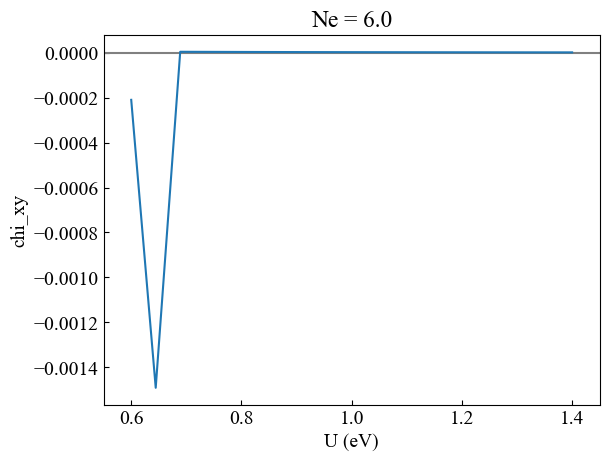

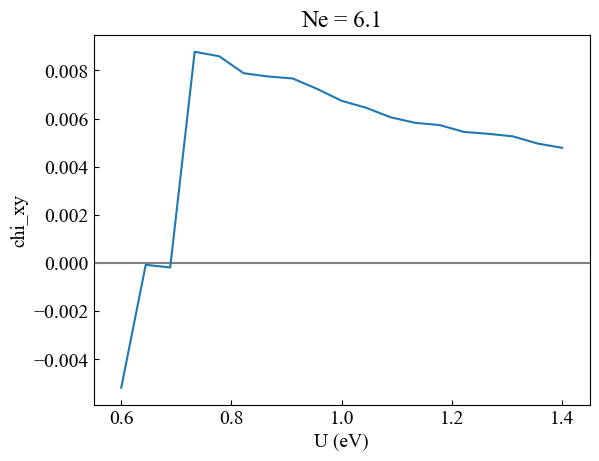

In [ ]:
for Ne in np.linspace(6.0,6.9, 10):
    Us = np.linspace(0.6, 1.4,19)
    chi_xy = []
    sigma_xy = []
    for U in Us:
        model = fs.KappaET2X(U, Ne, 101)
        model.calc_scf()
        model.calc_nscf()

        chi_xy.append(np.real(model.calc_spin_conductivity("x", "y")))

        # sigma_xy.append(np.real(model.calc_conductivity("x", "y")))

    chi_path = make_chi_graph(Us, chi_xy, Ne, "chi_xy")
    # sigma_path = make_graph(Us, sigma_xy, Ne, "sigma_xy")
    # post_image("Ne = {:.1f} での conductivity の計算が終わりました".format(Ne), chi_path)
    # post_image("電気伝導度".format(Ne), sigma_path)

    # notice("電気伝導度:".format(Ne))
    # export_graph(Us, sigma_xy, Ne, "sigma_xy")

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlim(0.55,1.45)
ax1.set_xlabel("U (eV)")
ax1.set_ylabel("$\chi /e$")
ax1.hlines(0, 0.55, 1.45, color="grey")

for Ne in np.linspace(6.0,6.9,10):
    chis = []
    Us = np.linspace(0.6, 1.4,20)
    for U in np.linspace(0.6, 1.4,20):
        model = fs.KappaET2X(U, Ne, 101)
        model.calc_scf()
        model.calc_nscf()
        chi = model.calc_spin_conductivity("x", "y")
        chis.append(chi)
        color = "tab:blue"

    ax1.plot(Us, chis, label = "Ne = {:.1f}".format(Ne))
    notice("Ne = {:.1f} の計算が終わりました".format(Ne))

# 出力
ax1.legend()
plt.savefig("./output/Chi.png")
plt.show()